# Script to sample from pretrained riff-cnet model

Requires GPU. Best to Run in Google Colab. Just clone the entire github into your drive and pull the model from HuggingFace as directed below to make this work. Make sure you have set up the control condas environment as well.

In [ ]:
# UNCOMMENT AND RUN NEEDED PIECES OF THIS BLOCK IF USING GOOGLE COLAB

from google.colab import drive
drive.mount("/content/drive/")

## cd into desired directory 
%cd drive/MyDrive/audio-inpainting-project/riff-cnet

# install dependencies
!pip install -q einops
!pip install -q omegaconf
!pip install -q transformers
!pip install -q open-clip-torch
!pip install -q pydub
!pip install -q pytorch_lightning==1.7.7 
!pip install -q fastcore -U

# # may need this if you get "module PIL has no attribute Transpose"
# !pip install -q Pillow==9.1.0

# # may need this if you get "module PIL has no attribute Resampling"

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

from riffusion.spectrogram_image_converter import SpectrogramImageConverter
from riffusion.spectrogram_params import SpectrogramParams

from cldm.ddim_hacked import DDIMSampler
from cnet_riff_dataset import CnetRiffDataset

# !pip install Pillow==9.0.0

from utils.cnet_utils import get_model, sample_ddim

!pip install -q Pillow==9.1.0

# # may need to pull updates
# !git pull

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/audio-inpainting-project/riff-cnet


## Loop through and get all contents

In [ ]:
# # PARAMETERS
control_methods = ["sobeldenoise"]
num_samples = 2      
root_save_dir = "experiment_samples_sobeldenoise_epoch_12"
# load model into pytorch 
mdl_paths = dict(canny="lightning_logs/version_6/checkpoints/epoch=5-step=27365.ckpt",
                 fullspec="lightning_logs/version_7/checkpoints/epoch=5-step=27365.ckpt",
                 sobel="lightning_logs/version_4/checkpoints/epoch=8-step=41048.ckpt",
                 sobeldenoisev0="lightning_logs/version_8/checkpoints/epoch=9-step=43448.ckpt", # first round of training, didn't work
                 sobeldenoisev1="lightning_logs/version_10/checkpoints/epoch=5-step=27365.ckpt", #6 epoch
                 sobeldenoise="lightning_logs/version_12/checkpoints/epoch=6-step=30287.ckpt") #12 epoch

img_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))

# generate the samples for the desired dataset
os.makedirs(root_save_dir, exist_ok=True)

for control_method in control_methods:

  # get new model
  model = get_model(mdl_paths[control_method])
  ddim_sampler = DDIMSampler(model)
  save_dir = os.path.join(root_save_dir,control_method)
  os.makedirs(save_dir, exist_ok=True)

  # get dataset
  val_dataset = CnetRiffDataset("val-data/", promptfile="prompt-"+control_method+".json")

  print(f"{control_method} model loaded!")

  for i, item in enumerate(val_dataset):
      # only sample a subset, like around 15 or so samples should be good
      if i%11 == 0:
          print(f"Sampling for prompt: {item['txt']}")
          results, _ = sample_ddim(item['hint'], 
                                   item['txt'], 
                                   model, 
                                   ddim_sampler, 
                                   num_samples=num_samples, 
                                   control_lims=[0.0,1.0])

          for (k, sample) in enumerate(results):
              # save each sample spectrogram
              cv2.imwrite(os.path.join(save_dir,f"{item['txt']}_samp_{k}.png"), sample)
              # save each sample audio
              sample_img = Image.open(os.path.join(save_dir,f"{item['txt']}_samp_{k}.png"))
              out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(sample_img, apply_filters=True).set_channels(2)
              out_audio_recon.export(os.path.join(save_dir,f"{item['txt']}_samp_{k}.wav"), format="wav")

          # save source for reference
          source = item['hint']
          if (np.max(source) <= 1) and (np.min(source) >= 0):
              print("switching control scale from [0.,1.] to [0,255]")
              source = np.uint8(source  * 255)
          cv2.imwrite(os.path.join(save_dir,f"{item['txt']}_source.png"), source)
          source_img = Image.open(os.path.join(save_dir,f"{item['txt']}_source.png")) 
          out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(source_img, apply_filters=True).set_channels(2)
          out_audio_recon.export(os.path.join(save_dir,f"{item['txt']}_source.wav"), format="wav") 

          # save target too
          target = (item['jpg'] + 1) / 2 * 255
          cv2.imwrite(os.path.join(save_dir,f"{item['txt']}_target.png"), target)
          target_img = Image.open(os.path.join(save_dir,f"{item['txt']}_target.png")) 
          out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(target_img, apply_filters=True).set_channels(2)
          out_audio_recon.export(os.path.join(save_dir,f"{item['txt']}_target.wav"), format="wav") 

  del model
  del ddim_sampler
  del val_dataset

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.16.mlp.fc1.bias', 'vision_model.encoder.layers.14.self_attn.out_proj.bias', 'vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.weight', 'vision_model.encoder.layers.5.mlp.fc2.weight', 'vision_model.encoder.layers.21.self_attn.v_proj.bias', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.6.mlp.fc1.bias', 'vision_model.encoder.layers.8.layer_norm2.bias', 'vision_model.encoder.layers.8.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.mlp.fc1

Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [lightning_logs/version_12/checkpoints/epoch=6-step=30287.ckpt]
sobeldenoise model loaded!


INFO:pytorch_lightning.utilities.seed:Global seed set to 1528


Sampling for prompt: Generate a male vocal rock melody with sustained notes.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:20<00:00,  1.62s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 46153


Sampling for prompt: Generate a female vocal pop melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 30709


Sampling for prompt: Generate a soulful female vocal pop melody with vocalizations.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 62728


Sampling for prompt: Generate a groovy female vocal pop melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 24679


Sampling for prompt: Generate a wistful oldies male vocal country melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 62937


Sampling for prompt: Generate a techno vocal pop melody with vocalizations and vocal runs.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 1049


Sampling for prompt: Generate a wistful tenor male vocal rock melody in the style of Freddie Mercury.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 59271


Sampling for prompt: Given Piano, Electric Bass, Percussive Organ, Harmonica, and Harmonica: Generate a Drum rhythm.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 54573


Sampling for prompt: Generate a Guitar line.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 35290


Sampling for prompt: Generate a Grand Piano.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 42570


Sampling for prompt: Given Drums, Piano, Electric Bass, Electric Guitar, Flute, Synth Voice, Electric Guitar, and Piano: Generate a Piano line.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 19344


Sampling for prompt: Generate a Electric Guitar part.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 53681


Sampling for prompt: Generate Electric Bass, Piano, and Drums.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 2704


Sampling for prompt: Given Drums, Piano, Electric Bass, and Electric Bass: Generate a Strings.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 15908


Sampling for prompt: Generate a Strings line.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 55056


Sampling for prompt: Given Synth Sawtooth Wave Lead, Strings, Piano, Acoustic Guitar, and Acoustic Bass: Generate a Strings part.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 13322


Sampling for prompt: Given Drums, Electric Bass, Grand Piano, Electric Guitar, Strings, Piano, and Synth Voice: Generate a Synth Pad part.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


switching control scale from [0.,1.] to [0,255]


## Testing Cnet Lite vs Cnet on old dataset

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import hf_hub_download

og_riffusion_path = hf_hub_download(repo_id="zachary-shah/riffusion-cnet-v2", filename="final_checkpoint.ckpt")


In [ ]:
!pip install -q Pillow==9.1.0


In [ ]:
# # PARAMETERS
num_samples = 2      
root_save_dir = "experiment_samples_cnetlite"
# load model into pytorch 
mdl_paths = dict(cnet=og_riffusion_path,
                 cnetlite="lightning_logs/version_20/checkpoints/epoch=17-step=39352.ckpt")

mdl_configs = dict(cnet="./models/cldm_v15.yaml",
                 cnetlite="./models/cldm_lite.yaml")


img_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))

# generate the samples for the desired dataset
os.makedirs(root_save_dir, exist_ok=True)

# old dataset (just generating melodies)
val_dataset = CnetRiffDataset("val-data/", promptfile="prompt.json")

for key in ["cnet"]:

    # get new model
    model = get_model(mdl_paths[key], mdl_configs[key])
    ddim_sampler = DDIMSampler(model)
    save_dir = os.path.join(root_save_dir,key)
    os.makedirs(save_dir, exist_ok=True)

    # get dataset
    
    print(f"{key} model loaded!")

    c = 0

    for i, item in enumerate(val_dataset):
        # only sample a subset, like around 15 or so samples should be good
        if i%11 == 0:
            c += 1
            print(f"Sampling for prompt: {item['txt']}")

            if key == "cnet":
                results, _ = sample_ddim(item['hint'], 
                                        item['txt'], 
                                        model, 
                                        ddim_sampler, 
                                        num_samples=num_samples, 
                                        control_lims=[0.0,255.0])
            else:
                results, _ = sample_ddim(item['hint'], 
                                        item['txt'], 
                                        model, 
                                        ddim_sampler, 
                                        num_samples=num_samples, 
                                        control_lims=[0.0,1.0])
                

            for (k, sample) in enumerate(results):
                # save each sample spectrogram
                cv2.imwrite(os.path.join(save_dir,f"{item['txt']}_samp_{k}.png"), sample)
                # save each sample audio
                sample_img = Image.open(os.path.join(save_dir,f"{item['txt']}_samp_{k}.png"))
                out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(sample_img, apply_filters=True).set_channels(2)
                out_audio_recon.export(os.path.join(save_dir,f"{item['txt']}_samp_{k}.wav"), format="wav")

            # save source for reference
            source = item['hint']
            if (np.max(source) <= 1) and (np.min(source) >= 0):
                print("switching control scale from [0.,1.] to [0,255]")
                source = np.uint8(source  * 255)
            cv2.imwrite(os.path.join(save_dir,f"{item['txt']}_source.png"), source)
            source_img = Image.open(os.path.join(save_dir,f"{item['txt']}_source.png")) 
            out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(source_img, apply_filters=True).set_channels(2)
            out_audio_recon.export(os.path.join(save_dir,f"{item['txt']}_source.wav"), format="wav") 

            # save target too
            target = (item['jpg'] + 1) / 2 * 255
            cv2.imwrite(os.path.join(save_dir,f"{item['txt']}_target.png"), target)
            target_img = Image.open(os.path.join(save_dir,f"{item['txt']}_target.png")) 
            out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(target_img, apply_filters=True).set_channels(2)
            out_audio_recon.export(os.path.join(save_dir,f"{item['txt']}_target.wav"), format="wav") 
          
        if c > 10:
            break

    del model
    del ddim_sampler

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.21.self_attn.q_proj.bias', 'vision_model.encoder.layers.19.layer_norm2.weight', 'vision_model.encoder.layers.3.self_attn.q_proj.weight', 'vision_model.encoder.layers.22.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.13.mlp.fc2.bias', 'vision_model.encoder.layers.22.mlp.fc1.bias', 'vision_model.encoder.layers.23.layer_norm2.bias', 'vision_model.encoder.layers.3.layer_norm2.weight', 'vision_model.encoder.layers.6.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.21.mlp.fc1.weight', 'vision_model.encoder.layers.23.self_at

Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [/root/.cache/huggingface/hub/models--zachary-shah--riffusion-cnet-v2/snapshots/25a4ab917a787a4ba1a1e26cc42c8d997ab3d05e/final_checkpoint.ckpt]


INFO:pytorch_lightning.utilities.seed:Global seed set to 27127


cnet model loaded!
Sampling for prompt: Generate an up-tempo female vocal rock melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 33322


Sampling for prompt: Generate a male vocal rock melody with sustained notes.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:17<00:00,  1.56s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 33341


Sampling for prompt: Generate an airy and sparse female vocal pop melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 12663


Sampling for prompt: Generate a female vocal melody in the style of Britney Spears.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 31327


Sampling for prompt: Generate a deep male vocal rock melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 34189


Sampling for prompt: Generate a soft male vocal rock melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 59294


Sampling for prompt: Generate a female vocal pop melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 64337


Sampling for prompt: Generate a groovy smooth female vocal pop chorus.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 9610


Sampling for prompt: Generate a female pop melody that sounds like Britney Spears singing Baby One More Time.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 18507


Sampling for prompt: Generate an uplifting female vocal pop melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


switching control scale from [0.,1.] to [0,255]


INFO:pytorch_lightning.utilities.seed:Global seed set to 20396


Sampling for prompt: Generate a soft male vocal rock melody.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


switching control scale from [0.,1.] to [0,255]


## Test just 1 sample and see contents for debugging:

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.21.layer_norm1.weight', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.layers.16.layer_norm2.bias', 'vision_model.encoder.layers.10.layer_norm2.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.self_attn.v_proj.weight', 'vision_model.encoder.layers.8.mlp.fc2.bias', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.22.layer_norm2.weight', 'vision_model.encoder.layers.11.self_attn.k_proj.bias', 'vision_model.encoder.layers.18.layer_norm2.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.

Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [lightning_logs/version_8/checkpoints/epoch=9-step=43448.ckpt]


INFO:pytorch_lightning.utilities.seed:Global seed set to 53088


Sampling for prompt: Generate a male vocal rock melody with sustained notes.
Data shape for DDIM sampling is (2, 4, 64, 64), eta 0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


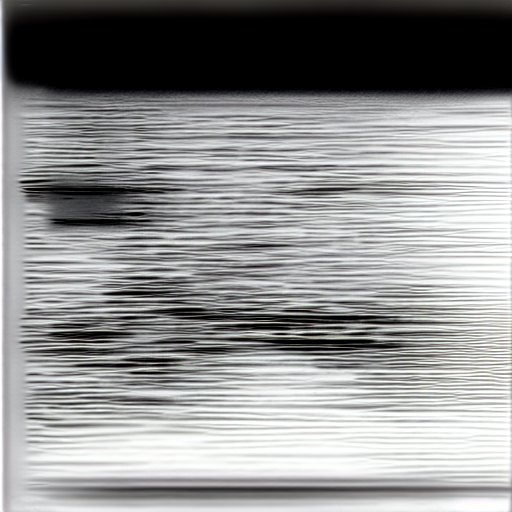

In [ ]:
# # PARAMETERS
control_method = "sobeldenoise" # do canny, fullspec, sobel, sobeldenoise
num_samples = 2      

# load model into pytorch 
mdl_paths = dict(canny="lightning_logs/version_6/checkpoints/epoch=5-step=27365.ckpt",
                 fullspec="lightning_logs/version_7/checkpoints/epoch=5-step=27365.ckpt",
                 sobel="lightning_logs/version_4/checkpoints/epoch=8-step=41048.ckpt",
                 sobeldenoise="lightning_logs/version_8/checkpoints/epoch=9-step=43448.ckpt")
model = get_model(mdl_paths[control_method])
ddim_sampler = DDIMSampler(model)

# get dataset
val_dataset = CnetRiffDataset("val-data/", promptfile="prompt-"+control_method+".json")

# before looping, just try 1. view sample spec
item = val_dataset[0]
print(f"Sampling for prompt: {item['txt']}")
results, _ = sample_ddim(item['hint'], 
                         item['txt'], 
                         model, 
                         ddim_sampler, 
                         control_lims=[0.0,1.0],
                         num_samples=num_samples)
results = results[0]
cv2.imwrite(os.path.join(f"test_samp.png"), results)
sample_img = Image.open(os.path.join(f"test_samp.png"))
sample_img

In [ ]:
# listen to sample audio:
sample_img = Image.open(os.path.join(f"test_samp.png"))
img_converter_to_audio = SpectrogramImageConverter(SpectrogramParams(sample_rate=44100, min_frequency=0, max_frequency=10000))
out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(sample_img, apply_filters=True).set_channels(2)
out_audio_recon

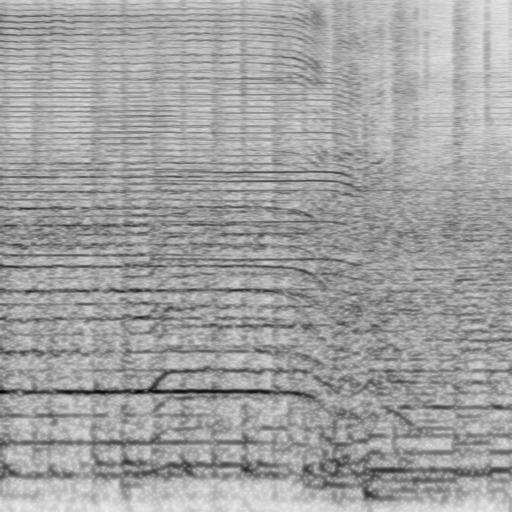

In [ ]:
# look at target
target = (item['jpg'] + 1) / 2 * 255
cv2.imwrite("test_target.png", target)
target_img = Image.open("test_target.png") 
target_img

In [ ]:
# listen to target audio 
out_audio_recon = img_converter_to_audio.audio_from_spectrogram_image(target_img, apply_filters=True).set_channels(2)
out_audio_recon